# Importing all the required `Libraries`

In [ ]:
import os 
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import keras
from keras.models import Sequential,Model
from keras.layers import Dense,Flatten,Dropout,BatchNormalization,Conv2D,MaxPool2D
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from  skimage.transform import resize
# from keras.utils import to_categorical
from keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.optimizers import RMSprop, Adam, SGD
import pickle

# Importing the data from `GitHub`

In [ ]:
!wget https://github.com/ShivamGS/SignLanguage/blob/main/Sign_Data.zip?raw=true

--2022-01-22 05:27:28--  https://github.com/ShivamGS/SignLanguage/blob/main/Sign_Data.zip?raw=true
Resolving github.com (github.com)... 140.82.113.4
Connecting to github.com (github.com)|140.82.113.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/ShivamGS/SignLanguage/raw/main/Sign_Data.zip [following]
--2022-01-22 05:27:28--  https://github.com/ShivamGS/SignLanguage/raw/main/Sign_Data.zip
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/ShivamGS/SignLanguage/main/Sign_Data.zip [following]
--2022-01-22 05:27:28--  https://raw.githubusercontent.com/ShivamGS/SignLanguage/main/Sign_Data.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response.

# Unzipping the data from Github

In [ ]:
!unzip "/content/Sign_Data.zip?raw=true"

Streaming output truncated to the last 5000 lines.
  inflating: Sign_Data/train/J/157.jpg  
  inflating: Sign_Data/train/J/158.jpg  
  inflating: Sign_Data/train/J/159.jpg  
  inflating: Sign_Data/train/J/16.jpg  
  inflating: Sign_Data/train/J/160.jpg  
  inflating: Sign_Data/train/J/161.jpg  
  inflating: Sign_Data/train/J/162.jpg  
  inflating: Sign_Data/train/J/163.jpg  
  inflating: Sign_Data/train/J/164.jpg  
  inflating: Sign_Data/train/J/165.jpg  
  inflating: Sign_Data/train/J/166.jpg  
  inflating: Sign_Data/train/J/167.jpg  
  inflating: Sign_Data/train/J/168.jpg  
  inflating: Sign_Data/train/J/169.jpg  
  inflating: Sign_Data/train/J/17.jpg  
  inflating: Sign_Data/train/J/170.jpg  
  inflating: Sign_Data/train/J/171.jpg  
  inflating: Sign_Data/train/J/172.jpg  
  inflating: Sign_Data/train/J/173.jpg  
  inflating: Sign_Data/train/J/174.jpg  
  inflating: Sign_Data/train/J/175.jpg  
  inflating: Sign_Data/train/J/176.jpg  
  inflating: Sign_Data/train/J/177.jpg  
  inflat

# Mounting Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Initializing the Training directory

In [ ]:
training_dir="/content/Sign_Data/train"
content=sorted(os.listdir(training_dir))
print(content)
len(content)

['1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']


35

# Initializing the Testing Directory

In [ ]:
testing_dir ="/content/Sign_Data/test"
content=sorted(os.listdir(testing_dir))
print(content)
len(content)

['1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']


35

# Building Training and testing data with Data augmentation for model training

In [ ]:
IMG_SIZE=(224,224)
BATCH_SIZE=32
train_generator=tf.keras.preprocessing.image_dataset_from_directory(directory=training_dir,
                                                                          image_size=IMG_SIZE,
                                                                          label_mode="categorical",
                                                                          batch_size=BATCH_SIZE)
                                                                          

validation_generator=tf.keras.preprocessing.image_dataset_from_directory(directory=testing_dir,
                                                              image_size=IMG_SIZE,
                                                              batch_size=BATCH_SIZE,
                                                              label_mode="categorical")

Found 10404 files belonging to 35 classes.
Found 3474 files belonging to 35 classes.


In [ ]:
training_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
      rescale = 1./255,
      rotation_range=40,
      horizontal_flip=True,
      width_shift_range=0.2, 
      height_shift_range=0.2,
      shear_range=0.2, 
      zoom_range=0.2,
      fill_mode='nearest' )

training_generator = training_datagen.flow_from_directory(
    training_dir, 
    subset="training", 
    shuffle=True, 
    seed=42,
    color_mode="rgb", 
    class_mode="categorical",
    target_size=IMG_SIZE,
    batch_size=64)

Found 10404 images belonging to 35 classes.


In [ ]:
testing_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
testing_generator = testing_datagen.flow_from_directory(
    testing_dir, 
    shuffle=False, 
    seed=42,
    color_mode="rgb",     
    class_mode="categorical",
    target_size=IMG_SIZE,
    batch_size=64)

Found 3474 images belonging to 35 classes.


In [ ]:
from tensorflow.keras import backend 

# Building model checkpoint callbacks

In [ ]:
LOSS_THRESHOLD = 0.2
ACCURACY_THRESHOLD = 0.979

class ModelCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if logs.get('val_loss') <= LOSS_THRESHOLD and logs.get('val_acc') >= ACCURACY_THRESHOLD:
      print("\nReached", ACCURACY_THRESHOLD * 100, "accuracy, Stopping!")
      self.model.stop_training = True

callback = ModelCallback()


In [ ]:
# Set data inputs 
import tensorflow as tf
IMG_SIZE=(224,224)
train_data_10_percent=tf.keras.preprocessing.image_dataset_from_directory(training_dir,
                                                                          label_mode="categorical",
                                                                          image_size=IMG_SIZE)

# test_data=tf.keras.preprocessing.image_dataset_from_directory(testing,
#                                                               label_mode="categorical",
#                                                               image_size=IMG_SIZE)

Found 10404 files belonging to 35 classes.


# Initializing EarlySoppingCallback

In [ ]:
early_stopping_callback=tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=5, restore_best_weights=True
)

# Building Feature Vectorizer using Tensorflow Hub

In [ ]:
import tensorflow_hub as hub

In [ ]:
feature_vectorizer=hub.KerasLayer("https://tfhub.dev/google/imagenet/inception_v2/feature_vector/5",
                                  input_shape=IMG_SIZE+(3,))

# Model Building using Functional API

Model Building follows Three steps:

1. Building the model

2. Compiling the model

3. Fitting the model



In [ ]:
inputs=tf.keras.layers.Input(shape=(224,224,3))
x=feature_vectorizer(inputs) 
x=tf.keras.layers.Flatten()(x)
x=tf.keras.layers.Dense(512, activation='relu')(x)
x=tf.keras.layers.Dense(256, activation='relu')(x)
# x=feature_vectorizer(x)
x=tf.keras.layers.Dense(128, activation='relu')(x)
x=tf.keras.layers.Dropout(0.2)(x)
outputs=tf.keras.layers.Dense(35,activation="softmax")(x)
model4=tf.keras.Model(inputs,outputs)
model4.summary()

# Compile the model
model4.compile(loss="categorical_crossentropy",
               optimizer="adam",
               metrics=["accuracy"])

# Fitting the model
history = model4.fit(
    training_generator,
    validation_data=testing_generator,
    steps_per_epoch=training_generator.samples//training_generator.batch_size,
    validation_steps=testing_generator.samples//testing_generator.batch_size,
    epochs=10,
    callbacks=[early_stopping_callback]
)



Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 keras_layer (KerasLayer)    (None, 1024)              10173112  
                                                                 
 flatten (Flatten)           (None, 1024)              0         
                                                                 
 dense (Dense)               (None, 512)               524800    
                                                                 
 dense_1 (Dense)             (None, 256)               131328    
                                                                 
 dense_2 (Dense)             (None, 128)               32896     
                                                                 
 dropout (Dropout)           (None, 128)               0     

In [ ]:
# model4.save("/content/drive/MyDrive/EDI_Model/model4.h5")

In [ ]:
model4 = tf.keras.models.load_model("/content/drive/MyDrive/EDI_Model/model4.h5",custom_objects={'KerasLayer':hub.KerasLayer})

In [ ]:
# acc = history.history['accuracy']
# val_acc = history.history['val_accuracy']
# loss = history.history['loss']
# val_loss = history.history['val_loss']

# epochs = range(len(acc))

# plt.plot(epochs, acc, 'r', label='Training accuracy')
# plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
# plt.title('Training and validation accuracy')
# plt.legend(loc=0)
# plt.figure()



# plt.show()

In [ ]:
# plt.plot(epochs, loss, 'r', label='Training loss')
# plt.plot(epochs, val_loss, 'b', label='Validationloss')
# plt.title('Training and validation loss')
# plt.legend(loc=0)
# plt.figure()

# Visualizing the model

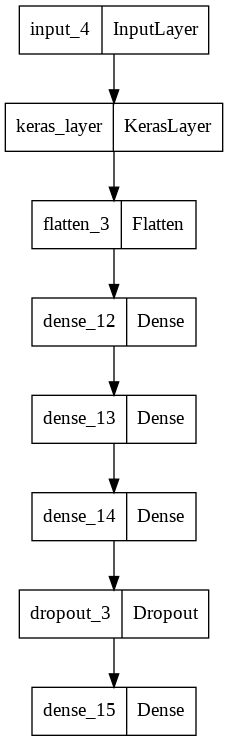

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(model4)

In [ ]:
from tensorflow.keras.utils import plot_model

# Building functions to evaluate final predictions

In [ ]:
def load_and_prep_image(filename, img_shape=224, scale=True):
  """
  Reads in an image from filename, turns it into a tensor and reshapes into
  (224, 224, 3).
  Parameters
  ----------
  filename (str): string filename of target image
  img_shape (int): size to resize target image to, default 224
  scale (bool): whether to scale pixel values to range(0, 1), default True
  """
  # Read in the image
  img = tf.io.read_file(filename)
  # Decode it into a tensor
  img = tf.image.decode_jpeg(img)
  # Resize the image
  img = tf.image.resize(img, [img_shape, img_shape])
  if scale:
    # Rescale the image (get all values between 0 and 1)
    return img/255.
  else:
    return img

In [ ]:
def pred_and_plot(filename, model=model4, class_names=train_generator.class_names):
  """
  Imports an image located at filename, makes a prediction on it with
  a trained model and plots the image with the predicted class as the title.
  """
  # Import the target image and preprocess it
  img = load_and_prep_image(filename)

  # Make a prediction
  pred = model.predict(tf.expand_dims(img, axis=0))

  # Get the predicted class
  if len(pred[0]) > 1: # check for multi-class
    pred_class = class_names[pred.argmax()] # if more than one output, take the max
  else:
    pred_class = class_names[int(tf.round(pred)[0][0])] # if only one output, round

  # Plot the image and predicted class
  plt.imshow(img)
  plt.title(f"Prediction: {pred_class}")
  plt.axis(False);

# Making predictions

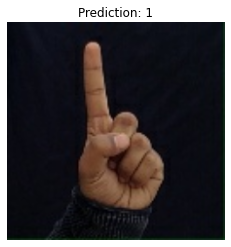

In [ ]:
pred_and_plot("/content/Sign_Data/train/1/10.jpg")

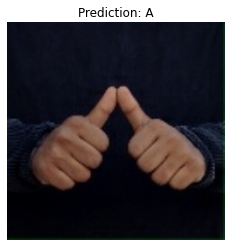

In [ ]:
pred_and_plot("/content/Sign_Data/train/A/102.jpg")

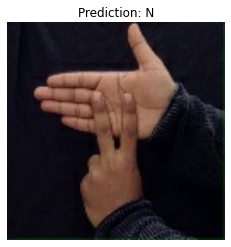

In [ ]:
pred_and_plot("/content/Sign_Data/train/N/101.jpg")

In [ ]:
pip install gradio

     |████████████████████████████████| 871 kB 5.3 MB/s 
     |████████████████████████████████| 1.1 MB 42.6 MB/s 
     |████████████████████████████████| 2.0 MB 37.1 MB/s 
     |████████████████████████████████| 54 kB 3.0 MB/s 
     |████████████████████████████████| 210 kB 58.1 MB/s 
     |████████████████████████████████| 52 kB 825 kB/s 
     |████████████████████████████████| 160 kB 54.5 MB/s 
     |████████████████████████████████| 144 kB 54.6 MB/s 
     |████████████████████████████████| 271 kB 54.3 MB/s 
     |████████████████████████████████| 10.9 MB 44.1 MB/s 
     |████████████████████████████████| 58 kB 6.0 MB/s 
     |████████████████████████████████| 79 kB 8.0 MB/s 
     |████████████████████████████████| 3.6 MB 37.4 MB/s 
     |████████████████████████████████| 856 kB 45.5 MB/s 
     |████████████████████████████████| 61 kB 465 kB/s 
     |████████████████████████████████| 58 kB 6.3 MB/s 
  Created wheel for ffmpy: filename=ffmpy-0.3.0-py3-none-any.whl size=4712 sha256=71

In [ ]:
import gradio as gr

In [ ]:
def load_and_prep_image2(filename, img_shape=224, scale=True):
  """
  Reads in an image from filename, turns it into a tensor and reshapes into
  (224, 224, 3).
  Parameters
  ----------
  filename (str): string filename of target image
  img_shape (int): size to resize target image to, default 224
  scale (bool): whether to scale pixel values to range(0, 1), default True
  """
  # Read in the image
  img = tf.io.read_file(filename)
  # # Decode it into a tensor
  img = tf.image.decode_jpg(img)
  # Resize the image
  img = tf.image.resize(img, [img_shape, img_shape])
  if scale:
    # Rescale the image (get all values between 0 and 1)
    return img/255.
  else:
    return img

In [ ]:
def start(filename,model=model4, class_names=train_generator.class_names):
  """
  Imports an image located at filename, makes a prediction on it with
  a trained model and plots the image with the predicted class as the title.
  """
  # Import the target image and preprocess it
  img = load_and_prep_image(filename)

  # Make a prediction
  pred = model.predict(tf.expand_dims(img, axis=0))

  # Get the predicted class
  if len(pred[0]) > 1: # check for multi-class
    pred_class = class_names[pred.argmax()] # if more than one output, take the max
  else:
    pred_class = class_names[int(tf.round(pred)[0][0])] # if only one output, round

  # Plot the image and predicted class
  return pred_class

In [ ]:
start("/content/Sign_Data/train/1/0.jpg")

'1'

In [ ]:
image=gr.inputs.Image(shape=(224,224))
gr.Interface(fn=start,inputs=["text"],outputs=["text"],capture_session=True).launch()

/usr/local/lib/python3.7/dist-packages/gradio/interface.py:224: UserWarning: The `capture_session` parameter in the `Interface` is deprecated and may be removed in the future.
  "The `capture_session` parameter in the `Interface`"


Colab notebook detected. To show errors in colab notebook, set `debug=True` in `launch()`
Running on public URL: https://47435.gradio.app

This share link expires in 72 hours. For free permanent hosting, check out Spaces (https://huggingface.co/spaces)


(<fastapi.applications.FastAPI at 0x7f10186a2950>,
 'http://127.0.0.1:7860/',
 'https://47435.gradio.app')

In [ ]:
model4.evaluate(testing_generator)

55/55 [==============================] - 19s 292ms/step - loss: 0.0060 - accuracy: 0.9986


[0.00603238632902503, 0.9985607266426086]

In [ ]:
model4.evaluate(training_generator)

163/163 [==============================] - 136s 832ms/step - loss: 0.0090 - accuracy: 0.9970


[0.00898443441838026, 0.9970203638076782]